In [11]:
%pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras cartopy

Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install kaggle kagglehub

Note: you may need to restart the kernel to use updated packages.


## Data Import

### We need to use Kaggle's API to download the data since it's too big to be uploaded to GitHub

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("usdot/flight-delays")

print("Path to dataset files:", path)

Path to dataset files: /Users/naominayman/.cache/kagglehub/datasets/usdot/flight-delays/versions/1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [15]:
import tensorflow as tf
from tensorflow import keras
# could be cool to do sometype of simple NN 

In [16]:
df = pd.read_csv(path + "/flights.csv")
airports = pd.read_csv(path + "/airports.csv")

/var/folders/78/46rnh6cd7w1dzd2t3dyd5t040000gn/T/ipykernel_20728/1086104120.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + "/flights.csv")


In [17]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

In [18]:
# for day of the week, 1 is Monday, 7 is Sunday
# we don't want any model to mistake the day of the week as numeric data
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].map({ 1: 'M',
                                            2: 'Tu',
                                            3: 'W',
                                            4: 'Th',
                                            5: 'F',
                                            6: 'Sa',
                                            7: 'Su'})

In [19]:
df.DEPARTURE_DELAY = df.DEPARTURE_DELAY.dropna() # drop NaN
df.ARRIVAL_DELAY = df.ARRIVAL_DELAY.dropna() # drop NaN

In [20]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,Th,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,Th,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,Th,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,Th,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,Th,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### We need to decide how long the departure/arrival delay needs to be to classify as a significant delay

This is just my data exploration

In [21]:
df.DEPARTURE_DELAY.describe(), df.ARRIVAL_DELAY.describe()

(count    5.732926e+06
 mean     9.370158e+00
 std      3.708094e+01
 min     -8.200000e+01
 25%     -5.000000e+00
 50%     -2.000000e+00
 75%      7.000000e+00
 max      1.988000e+03
 Name: DEPARTURE_DELAY, dtype: float64,
 count    5.714008e+06
 mean     4.407057e+00
 std      3.927130e+01
 min     -8.700000e+01
 25%     -1.300000e+01
 50%     -5.000000e+00
 75%      8.000000e+00
 max      1.971000e+03
 Name: ARRIVAL_DELAY, dtype: float64)

In [22]:
df.DEPARTURE_DELAY.value_counts().sort_index()

DEPARTURE_DELAY
-82.0      1
-68.0      1
-61.0      1
-56.0      1
-55.0      1
          ..
 1631.0    1
 1649.0    1
 1670.0    1
 1878.0    1
 1988.0    1
Name: count, Length: 1217, dtype: int64

In [23]:
df.ARRIVAL_DELAY.value_counts().sort_index()

ARRIVAL_DELAY
-87.0      2
-82.0      1
-81.0      2
-80.0      3
-79.0      2
          ..
 1636.0    2
 1638.0    1
 1665.0    1
 1898.0    1
 1971.0    1
Name: count, Length: 1240, dtype: int64

In [24]:
len(df.columns)

31

In [25]:
# We need to do some data exploration for the columns that we want to use
# we'll definitely need to drop some columns and rows
# we'll also need to figure out which airports we want to keep because it'd be too much to encode all of them

## Plot airports on a map and maybe cluster based on geographic location

In [26]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


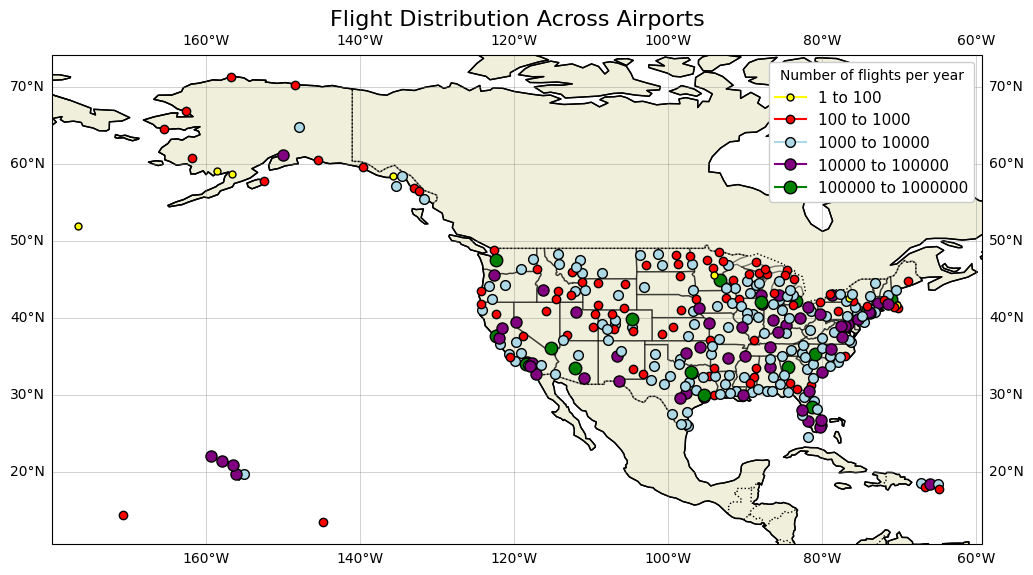

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from collections import OrderedDict

# Define properties of markers and labels
count_flights = df['ORIGIN_AIRPORT'].value_counts()
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []

for i in range(len(size_limits)-1):
    labels.append(f"{size_limits[i]} to {size_limits[i+1]}")

# Create a figure with a geographic projection
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='-', alpha=0.5)

ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

# Plot airports on the map
for index, (code, y, x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    isize = [i for i, val in enumerate(size_limits) if val < count_flights.get(code, 0)]
    if isize:  # Check if the airport has flight counts within defined limits
        ind = isize[-1]
        ax.plot(x, y, marker='o', markersize=ind+5, markeredgewidth=1, 
                color=colors[ind], markeredgecolor='k', 
                transform=ccrs.PlateCarree(), label=labels[ind])


handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 to 100', '100 to 1000', '1000 to 10000',
             '10000 to 100000', '100000 to 1000000')
new_label = OrderedDict()
for key in key_order:
    if key in by_label:
        new_label[key] = by_label[key]

# Add a legend
plt.legend(new_label.values(), new_label.keys(), loc='upper right', prop={'size':11},
           title='Number of flights per year', frameon=True, framealpha=1)

# Show the map
plt.title("Flight Distribution Across Airports", fontsize=16)
plt.show()

### temporary airport location grouping by west coast, midwest, east coast, south

### will need prof advice how to do this better


In [28]:
#joining on origin airport
df = df.join(airports.set_index('IATA_CODE'), on='ORIGIN_AIRPORT', how='inner')


In [29]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,2015,1,1,Th,AS,98,N407AS,ANC,SEA,5,...,NaN,NaN,NaN,NaN,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
1,2015,1,1,Th,AA,2336,N3KUAA,LAX,PBI,10,...,NaN,NaN,NaN,NaN,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
2,2015,1,1,Th,US,840,N171US,SFO,CLT,20,...,NaN,NaN,NaN,NaN,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484
3,2015,1,1,Th,AA,258,N3HYAA,LAX,MIA,20,...,NaN,NaN,NaN,NaN,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
4,2015,1,1,Th,AS,135,N527AS,SEA,ANC,25,...,NaN,NaN,NaN,NaN,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931


In [30]:
def group_states(row):
    if row in ['CA', 'WA', 'OR', 'AK', 'HI', 'AZ', 'NV', 'UT', 'ID', 'MT', 'WY', 'CO', 'NM']:
        return 'west'
    elif row in ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH']:
        return 'midwest'
    elif row in ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL', 'SC', 'NC', 'TN', 'KY']:
        return 'south'
    elif row in ['PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'NH', 'VT', 'ME', 'DE', 'MD', 'VA', 'WV', 'DC']:
        return 'east'
    else:
        return 'Other'

In [31]:
# group origin airport states into regions
df['OA_grouped'] = df['STATE'].map(group_states)

In [32]:
#remove join on airports and origin airport
df.drop(['AIRPORT', 'CITY','STATE', 'COUNTRY', 'LATITUDE', "LONGITUDE"], axis=1, inplace=True)

In [33]:
#now join on destination airport
df = df.join(airports.set_index('IATA_CODE'), on='DESTINATION_AIRPORT', how='inner')

In [34]:
# map destination airport states into regions
df['DA_grouped'] = df['STATE'].map(group_states)

In [35]:
# remove airport information since we don't need it anymore
df.drop(['AIRPORT', 'CITY','STATE', 'COUNTRY', 'LATITUDE', "LONGITUDE"], axis=1, inplace=True)

In [36]:
# now we have grouped airport regions so one hot encoding them will be much easier
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,OA_grouped,DA_grouped
0,2015,1,1,Th,AS,98,N407AS,ANC,SEA,5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,west
1,2015,1,1,Th,AA,2336,N3KUAA,LAX,PBI,10,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,south
2,2015,1,1,Th,US,840,N171US,SFO,CLT,20,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,south
3,2015,1,1,Th,AA,258,N3HYAA,LAX,MIA,20,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,south
4,2015,1,1,Th,AS,135,N527AS,SEA,ANC,25,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,west


In [50]:
# create the target variable
df['target'] = (
    (df['ARRIVAL_DELAY'] > 10) |
    (df['DEPARTURE_DELAY'] > 10) |
    (df['CANCELLED'] == 1) |
    (df['DIVERTED'] == 1) |
    (df['AIR_SYSTEM_DELAY'] > 10) |
    (df['SECURITY_DELAY'] > 10) |
    (df['AIRLINE_DELAY'] > 10) |
    (df['LATE_AIRCRAFT_DELAY'] > 10) |
    (df['WEATHER_DELAY'] > 10))

df.target = df.target.astype(int)

## View correlation and linearity between features

In [49]:
features = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'OA_grouped', 'DA_grouped', 'SCHEDULED_DEPARTURE']

In [ ]:
from scipy.stats import chi2_contingency

def chi_squared_test(df, features, target):
    results = []
    for feature in features:
        contingency_table = pd.crosstab(df[feature], df[target]) 
        chi2, p, dof, expected = chi2_contingency(contingency_table)  # Perform chi-squared test
        results.append({
            'Feature': feature,
            'Chi2 Statistic': chi2,
            'P-Value': f"{p:.4e}",
            'Degrees of Freedom': dof
        })
    return pd.DataFrame(results)

# Perform the test
chi_squared_results = chi_squared_test(df, features, "target")

# Display the results
print(chi_squared_results)


               Feature  Chi2 Statistic     P-Value  Degrees of Freedom
0                MONTH    46693.097763  0.0000e+00                  10
1                  DAY     9997.955886  0.0000e+00                  30
2          DAY_OF_WEEK     6214.546280  0.0000e+00                   6
3              AIRLINE    50310.231519  0.0000e+00                  13
4           OA_grouped     5087.561491  0.0000e+00                   4
5           DA_grouped     6004.727373  0.0000e+00                   4
6  SCHEDULED_DEPARTURE   162767.533940  0.0000e+00                1317


since p-value is 0, this means the features are statistically significant and have high correlation with the target variable


## Create a model and figure out the feature encoding

In [37]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'OA_grouped', 'DA_grouped'],
      dtype='object')

In [38]:
# We may want to use tail number as a feature, but there are too many unique values, find a way to group these
df.TAIL_NUMBER.value_counts()

TAIL_NUMBER
N480HA    3446
N488HA    3390
N484HA    3343
N493HA    3295
N478HA    3237
          ... 
N860NW       1
N7LBAA       1
N7LEAA       1
N826MH       1
N175UA       1
Name: count, Length: 4896, dtype: int64

In [41]:
# The target variable classes are unbalanced since there are double the amount of 0s than 1s
df.target.value_counts()

target
0    3792169
1    1540745
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder

tree = DecisionTreeClassifier()

# one hot encode the categorical variables
ohe = OneHotEncoder()


# we'll sample the data to make it faster to work with
df_sample = df.sample(frac=0.2, replace=False, random_state=42)

features_ohe = ohe.fit_transform(df_sample[features].astype(str))

# split the data
X_train, X_test, y_train, y_test = train_test_split(features_ohe, df_sample['target'], test_size=0.2, random_state=42)

# fit the model
tree.fit(X_train, y_train)


DecisionTreeClassifier()

In [56]:
from sklearn.metrics import precision_score, confusion_matrix, recall_score, accuracy_score, f1_score
y_pred_train = tree.predict(X_train)
print(f'Train Confusion Matrix: {confusion_matrix(y_train, y_pred_train)}') 
print(f'Train Precision: {precision_score(y_train, y_pred_train)}')
print(f'Train Recall: {recall_score(y_train, y_pred_train)}')
print(f'Train Accuracy: {accuracy_score(y_train, y_pred_train)}')
print(f'Train F1 Score: {f1_score(y_train, y_pred_train)}')

Train Confusion Matrix: [[606267   1262]
 [ 20583 225154]]
Train Precision: 0.9944261889619108
Train Recall: 0.91623971970033
Train Accuracy: 0.974398370496422
Train F1 Score: 0.9537332178340495


In [57]:
y_pred = tree.predict(X_test)
print(f'Test Confusion Matrix: {confusion_matrix(y_test, y_pred)}') 
print(f'Test Precision: {precision_score(y_test, y_pred)}')
print(f'Test Recall: {recall_score(y_test, y_pred)}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Test F1 Score: {f1_score(y_test, y_pred)}')

Test Confusion Matrix: [[125485  26119]
 [ 40677  21036]]
Test Precision: 0.44610327642879866
Test Recall: 0.3408682125322055
Test Accuracy: 0.6868697759672225
Test F1 Score: 0.38644964544218685


very high train accuracy and low test accuracy, high variance and low bias, suggesting the model is overfit

need to consider different data scaling techniques, such as one hot encoding for airlines and airports but a different method for month day scheduled departure and day of the week since they're not quite categorical or continuous 